In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
data = pd.read_excel("C:/Users/user/Downloads/cardiotocography/CTG.xls", sheet_name='Raw Data')

# ⛏️ 2. Алдын ала өңдеу
# Соңғы жолдарда 'NaN' немесе бос жолдар бар болса, оларды алып тастаймыз
data = data.dropna()

# Бос бағандарды алып тастаймыз
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

# Таргет - 'NSP' (Normal/Suspect/Pathological)
X = data.drop(columns='NSP')
y = data['NSP']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [18]:
X_train_encoded = X_train.copy()

for col in X_train_encoded.select_dtypes(include='datetime').columns:
    X_train_encoded[col + '_year'] = X_train_encoded[col].dt.year
    X_train_encoded[col + '_month'] = X_train_encoded[col].dt.month
    X_train_encoded[col + '_day'] = X_train_encoded[col].dt.day
    X_train_encoded[col + '_weekday'] = X_train_encoded[col].dt.weekday
    X_train_encoded.drop(columns=col, inplace=True)  # удаляем исходный datetime

for col in X_train_encoded.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X_train_encoded[col] = le.fit_transform(X_train_encoded[col])


In [20]:
dt_params = {
    'max_depth': [3, 5, 10, None],
    'min_samples_leaf': [1, 5, 10]
}
dt_model = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=dt_params,
    cv=5,
    n_jobs=-1
)
dt_model.fit(X_train_encoded, y_train)

rf_params = {
    'n_estimators': [100],
    'max_depth': [5, 10, None],
    'min_samples_leaf': [1, 5]
}
rf_model = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=rf_params,
    cv=5,
    n_jobs=-1
)
rf_model.fit(X_train_encoded, y_train)

y_train_xgb = y_train.astype(int) - 1  # если классы начинаются с 1, а не с 0

xgb_params = {
    'max_depth': [3, 5, 10],
    'gamma': [0, 0.1, 0.5]
}
xgb_model = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    param_grid=xgb_params,
    cv=5,
    n_jobs=-1
)
xgb_model.fit(X_train_encoded, y_train_xgb)


c:\Users\user\OneDrive\Desktop\bike\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:56:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'gamma': [0, 0.1, 0.5], 'max_depth': [3, 5, 10]})

In [25]:
X_test_encoded = X_test.copy()

# Разбиваем дату
X_test_encoded['Date'] = pd.to_datetime(X_test_encoded['Date'])
X_test_encoded['Date_year'] = X_test_encoded['Date'].dt.year
X_test_encoded['Date_month'] = X_test_encoded['Date'].dt.month
X_test_encoded['Date_day'] = X_test_encoded['Date'].dt.day
X_test_encoded['Date_weekday'] = X_test_encoded['Date'].dt.weekday
X_test_encoded = X_test_encoded.drop('Date', axis=1)

# Кодируем категориальные признаки
for col in X_test_encoded.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X_test_encoded[col] = le.fit_transform(X_test_encoded[col])

for name, model in models.items():
    y_pred = model.predict(X_test_encoded)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{name} - Accuracy: {acc:.3f}")
    print(classification_report(y_test, y_pred))

    # ROC AUC (One-vs-Rest)
    y_proba = model.predict_proba(X_test_encoded)
    roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
    print(f"{name} - ROC AUC (OvR): {roc_auc:.3f}")




Decision Tree - Accuracy: 0.969
              precision    recall  f1-score   support

         1.0       0.97      1.00      0.98       332
         2.0       0.96      0.81      0.88        59
         3.0       1.00      0.97      0.99        35

    accuracy                           0.97       426
   macro avg       0.98      0.93      0.95       426
weighted avg       0.97      0.97      0.97       426

Decision Tree - ROC AUC (OvR): 0.929

Random Forest - Accuracy: 0.981
              precision    recall  f1-score   support

         1.0       0.98      1.00      0.99       332
         2.0       1.00      0.86      0.93        59
         3.0       1.00      1.00      1.00        35

    accuracy                           0.98       426
   macro avg       0.99      0.95      0.97       426
weighted avg       0.98      0.98      0.98       426

Random Forest - ROC AUC (OvR): 0.997

XGBoost - Accuracy: 0.002
              precision    recall  f1-score   support

         0.0    

c:\Users\user\OneDrive\Desktop\bike\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\OneDrive\Desktop\bike\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\OneDrive\Desktop\bike\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result

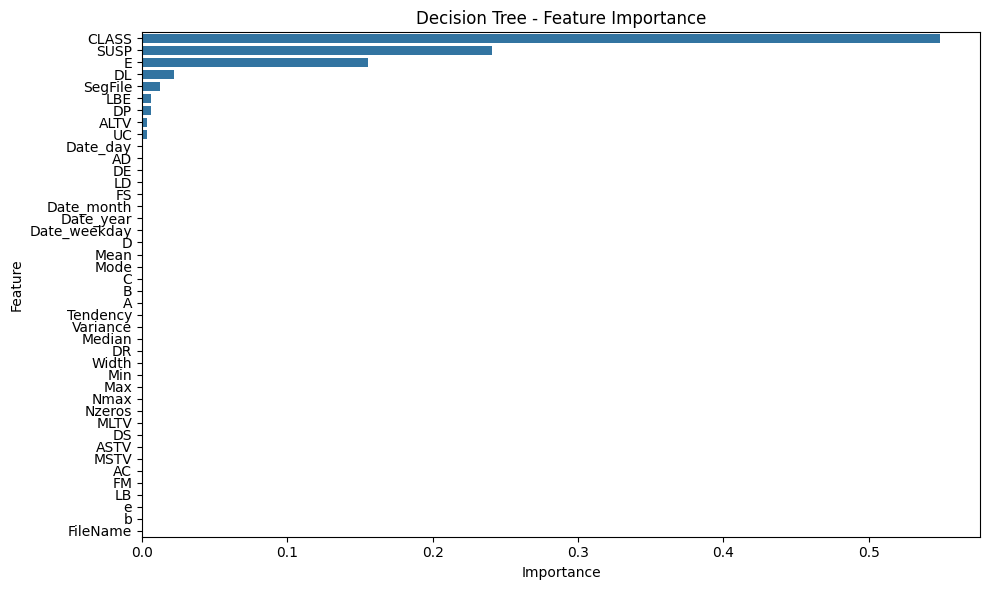

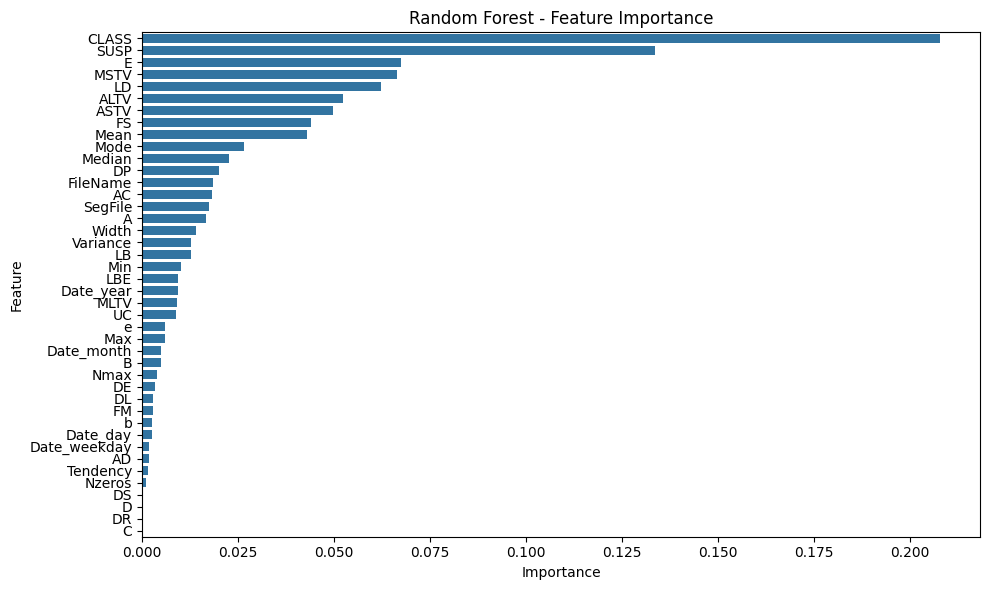

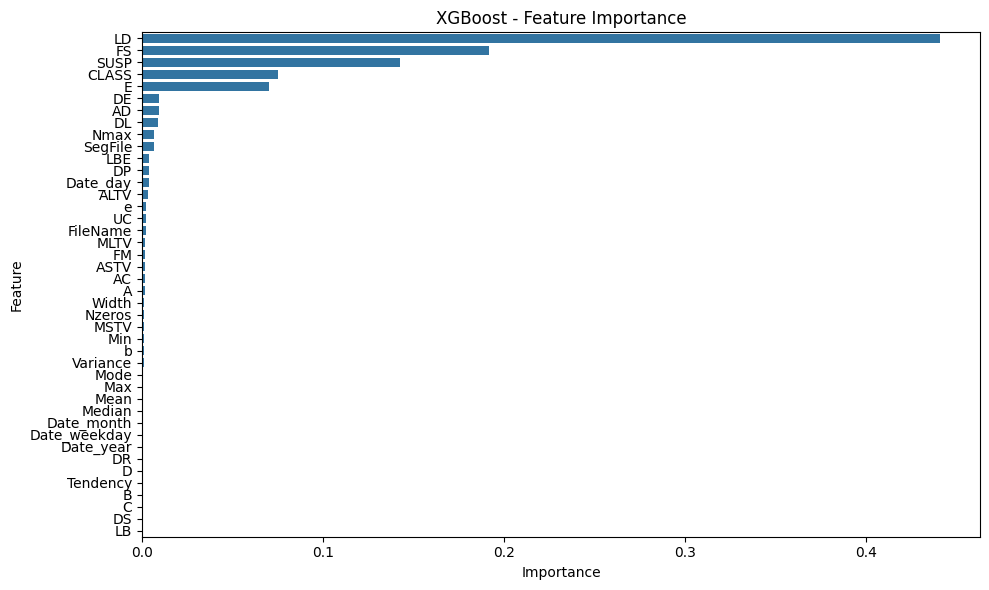

In [27]:
def plot_importance(model, model_name, feature_names):
    importances = model.best_estimator_.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[indices], y=np.array(feature_names)[indices])
    plt.title(f"{model_name} - Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

# Используем X_train_encoded.columns, потому что модель обучалась на этих признаках
for name, model in models.items():
    plot_importance(model, name, X_train_encoded.columns)
